

# Analisis Preferensi Pengguna Perusahaan Zuber

## Konten<a id='back'></a>

* [Pendahuluan](#intro)
* [Tahap 1. Inisialisasi data](#inisial)
* [Tahap 2. Mempersiapkan data data](#prepare)
* [Tahap 3. Analisa Data](#analyze)
* [Tahap 4. Hipotesis](#hypothesis)
* [Kesimpulan Umum](#conclusion)
    * [Temuan](#end)
    * [Rekomendasi](#recom)

## Pendahuluan<a id='intro'></a>

Kamu bekerja sebagai seorang analyst untuk Zuber, sebuah perusahaan berbagi tumpangan (ride-sharing) baru yang diluncurkan di Chicago. Tugasmu adalah untuk menemukan pola pada informasi yang tersedia. Kamu ingin memahami preferensi penumpang dan dampak faktor eksternal terhadap perjalanan.

Kamu akan mempelajari database, menganalisis data dari kompetitor, dan menguji hipotesis tentang pengaruh cuaca terhadap frekuensi perjalanan. 

Deskripsi data
Database yang memuat informasi perjalanan taksi di Chicago:

Tabel `neighborhoods`: data terkait wilayah di kota Chicago
* name: nama wilayah
* neighborhood_id: kode wilayah

Tabel `cabs`: data terkait taksi
* cab_id: kode kendaraan
* vehicle_id: ID teknis kendaraan
* company_name: nama perusahaan yang memiliki kendaraan

Tabel `trips`: data terkait perjalanan
* trip_id: kode perjalanan
* cab_id: kode kendaraan yang beroperasi
* start_ts: tanggal dan waktu perjalanan dimulai (waktu dibulatkan dalam satuan jam)
* end_ts: tanggal dan waktu perjalanan berakhir (waktu dibulatkan dalam satuan jam)
* duration_seconds: durasi perjalanan dalam satuan detik
* distance_miles: jarak perjalanan dalam satuan mil
* pickup_location_id: kode wilayah penjemputan
* dropoff_location_id: kode wilayah pengantaran

Tabel `weather_records`: data terkait cuaca
* record_id: kode catatan cuaca
* ts: tanggal dan waktu saat pencatatan cuaca dilakukan (waktu dibulatkan dalam satuan jam)
* temperature: suhu saat pencatatan cuaca dilakukan
description: deskripsi singkat tentang kondisi cuaca, seperti "light rain" (hujan ringan) atau "scattered clouds" (berawan)

Catatan: tidak ada hubungan langsung antara tabel trips dan weather_records di database. Namun, kamu tetap bisa menggunakan JOIN dan menghubungkan kedua tabel menggunakan data waktu perjalanan dimulai (trips.start_ts) dan waktu pencatatan cuaca (weather_records.ts).

Selain data di atas, ada lagi data lainnya yaitu:
project_sql_result_01.csv. File ini memuat data berikut:
- company_name: nama perusahaan taksi
- trips_amount: jumlah perjalanan untuk setiap perusahaan taksi pada tanggal 15-16 November 2017

project_sql_result_04.csv. File ini memuat data berikut:
- dropoff_location_name: nama wilayah di Chicago tempat perjalanan berakhir
- average_trips: jumlah rata-rata perjalanan yang berakhir di setiap wilayah pada bulan November 2017

project_sql_result_07.csv — hasil dari kueri terakhir. File ini memuat data perjalanan dari Loop ke Bandara Internasional O'Hare dengan kolom-kolom yang ada di tabel ini:
- start_ts -- tanggal dan waktu penjemputan
- weather_conditions -- kondisi cuaca saat perjalanan dimulai
- duration_seconds -- durasi perjalanan dalam satuan detik


## Inisialisasi<a id='inisial'></a>

Memuat semua library yang dibutuhkan:

In [200]:
# Memuat semua library
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mt
from matplotlib import pyplot as plt
from math import factorial
from scipy.stats import norm
import seaborn as sns
from dateutil.relativedelta import relativedelta
from datetime import datetime
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import levene

## Mempersiapkan Data<a id='prepare'></a>

memasukkan semua data:

In [201]:
# Memuat file data ke dalam DataFrame 
sql1 = pd.read_csv('/datasets/project_sql_result_01.csv') 
sql4 = pd.read_csv('/datasets/project_sql_result_04.csv') 
sql7 = pd.read_csv('/datasets/project_sql_result_07.csv')

### Memeriksa file  `/datasets/project_sql_result_01.csv`

In [202]:
#memuat data
sql1.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


In [203]:
#memuat informasi umum
sql1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


terlihat bahwa data hanya berisi 2 kolom `company_name` dan `trips_amount` sebanyak 64 data, dan tidak memiliki data yang hilang. serta tipe data yang sudah sesuai.

In [204]:
#memeriksa duplicate
sql1.duplicated().sum()

0

terlihat bahwa data tersebut tidak memiliki duplikasi sehingga tidak diperlukan penanganan lebih lanjut

In [205]:
#memuat informasi umum tambahan
sql1.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


### Memeriksa file `/datasets/project_sql_result_04.csv`

In [206]:
#memuat data
sql4.head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


In [207]:
#memuat informasi umum
sql4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


terlihat bahwa data hanya berisi 2 kolom `dropoff_location_name` dan `average_trips` sebanyak 94 data, dan tidak memiliki data yang hilang. serta tipe data yang sudah sesuai.

In [208]:
#memeriksa duplicate
sql4.duplicated().sum()

0

terlihat bahwa data tersebut tidak memiliki duplikasi sehingga tidak diperlukan penanganan lebih lanjut

In [209]:
#memuat informasi umum tambahan
sql4.describe()

,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


### Memeriksa file `/datasets/project_sql_result_07.csv`

In [210]:
#memuat data
sql7.head(10)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


In [211]:
#memuat informasi umum
sql7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


terlihat bahwa data hanya berisi 3 kolom `start_ts`, `weather_conditions` dan `duration_seconds` sebanyak 1068 data, dan tidak memiliki data yang hilang. akan tetapi kolom `starts_ts` memiliki tipe data yang salah sehingga harus diubah menjadi datetime.

In [212]:
#Merubah data start_ts menjadi datetime
sql7['start_ts'] = pd.to_datetime(sql7['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [213]:
#memuat informasi umum
sql7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


sekarang kolom `start_ts` sudah memiliki tipe data datetime

In [214]:
#memeriksa duplicate
sql7.duplicated().sum()

197

terlihat banyak sekali data yang terduplikat mari kita periksa apa kemungkinan penyebab ini terjadi sebelum melanjutkan ke tahap selanjutnya

In [215]:
#memeriksa kolom kualitatif
sql7['weather_conditions'].unique()

array(['Good', 'Bad'], dtype=object)

sepertinya banyaknya duplikasi disebabkan oleh nilai kualitatif pada kolom `weather_conditions` yang hanya memiliki 2 variabel. diputuskan untuk memangkas kolom yang terduplicate

In [216]:
#menghapus duplikat
sql7.drop_duplicates(inplace=True)

In [217]:
#memeriksa duplicate
sql7.duplicated().sum()

0

In [218]:
#memuat informasi umum
sql7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            871 non-null    datetime64[ns]
 1   weather_conditions  871 non-null    object        
 2   duration_seconds    871 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 27.2+ KB


sekarang dataframe `sql7` hanya memiliki 871 data

In [219]:
#memuat informasi umum tambahan
sql7.describe()

,duration_seconds
count,871.000000
mean,2096.308840
std,782.274717
min,0.000000
25%,1440.000000
50%,2015.000000
75%,2584.000000
max,7440.000000


**Kesimpulan:** hampir semua data sudah memiliki informasi yang jelas, hanya saja pada dataframe `sql7` ada kolom yang memiliki tipe data yang salah dan memiliki duplikasi data sehingga diputuskan untuk menghapusnya

## Analisa Data<a id='analyze'></a>

### mengidentifikasi 10 wilayah teratas yang dijadikan sebagai titik pengantaran

In [220]:
# mengidentifikasi 10 wilayah teratas yang dijadikan sebagai titik pengantaran
dropoff = sql4.sort_values(by='average_trips', ascending=False).reset_index()

#memotong tabel hanya 10 besar
topten_dropoff = dropoff.query('index < 10')   
topten_dropoff

,index,dropoff_location_name,average_trips
0,0,Loop,10727.466667
1,1,River North,9523.666667
2,2,Streeterville,6664.666667
3,3,West Loop,5163.666667
4,4,O'Hare,2546.900000
5,5,Lake View,2420.966667
6,6,Grant Park,2068.533333
7,7,Museum Campus,1510.000000
8,8,Gold Coast,1364.233333
9,9,Sheffield & DePaul,1259.766667


10 wilayah teratas yang dijadikan sebagai titik pengantaran adalah `Loop`, `River North`, `Streeterville`, `West Loop`, `O'Hare`, `Lake View`, `Grant Park`, `Museum Campus`, `Gold Coast` dan `Sheffiled & DePaul`. 

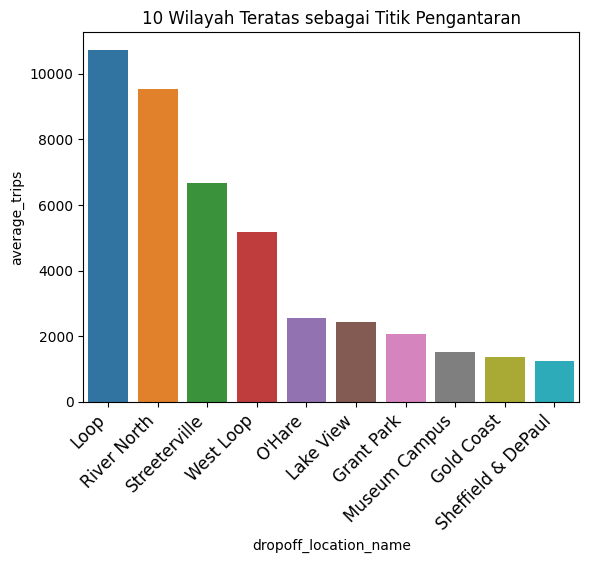

In [221]:
sns.barplot(data=topten_dropoff, x="dropoff_location_name", y="average_trips")
plt.title('10 Wilayah Teratas sebagai Titik Pengantaran')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

### 10 teratas Perusahaan taksi dan jumlah perjalanannya

In [222]:
# Perusahaan taksi dan jumlah perjalanannya
top_taxicompany = sql1.sort_values(by='trips_amount', ascending=False)

#memotong tabel hanya 10 besar
topten_taxicompany = top_taxicompany.head(10)   
topten_taxicompany

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


10 perusahaan teratas  adalah `Flash Cab`, `Taxi Affiliation Services`, `Medallion Leasing`, `Yellow Cab`, `Taxi Affiliation Service Yellow`, `Chicago Carriage Cab Corp`, `City Service`, `Sun Taxi`, `Star North Management LLC` dan `Blue Ribbon Taxi Association Inc.`. 

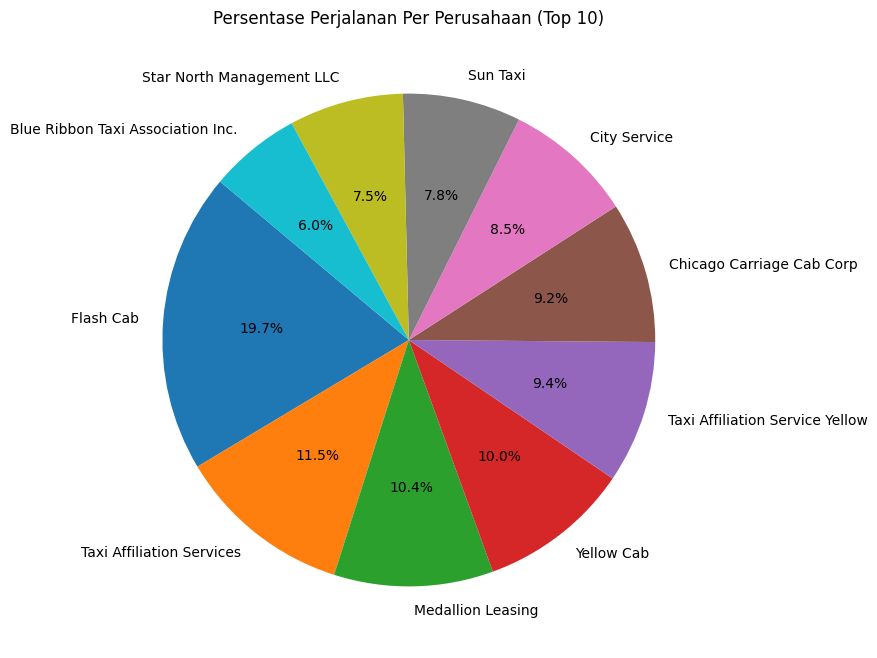

In [223]:
# Membuat pie chart
plt.figure(figsize=(9, 8))  # Mengatur ukuran gambar

# Data untuk pie chart
labels = topten_taxicompany['company_name']
sizes = topten_taxicompany['trips_amount']

# Membuat pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

# Menambahkan judul
plt.title('Persentase Perjalanan Per Perusahaan (Top 10)')

# Menampilkan pie chart
plt.show()

## Hipotesis<a id='hypotheses'></a>

### Hipotesis 1

Hipotesis:
Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare berubah saat hujan di hari Sabtu.

- <font color='blue'>H0 : Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare SAMA saat hujan ataupun cerah pada hari Sabtu.</font>
- <font color='red'>H1 : Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare TIDAK SAMA saat hujan ataupun cerah pada hari Sabtu.</font>

`Alpha : 0.05`

In [224]:
#memuat data
sql7.head(10)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


In [225]:
# memfilter dataset weather untuk cuaca yang baik dan cuaca yang buruk
good_weather = sql7.query('weather_conditions == "Good"')
bad_weather = sql7.query('weather_conditions == "Bad"')

# besarnya signifikan level
alpha = 0.05

# Uji Levene untuk memeriksa kesamaan varians
levene_stat, levene_pvalue = st.levene(good_weather['duration_seconds'], bad_weather['duration_seconds'])
print(f'Nilai p-value Uji Levene: {levene_pvalue}')

# Uji hipotesis berdasarkan hasil Uji Levene
if levene_pvalue < alpha:
    # Varians tidak sama, menggunakan t-test dengan equal_var=False
    result = st.ttest_ind(good_weather['duration_seconds'], bad_weather['duration_seconds'], equal_var=False)
else:
    # Varians sama, menggunakan t-test standar
    result = st.ttest_ind(good_weather['duration_seconds'], bad_weather['duration_seconds'], equal_var=True)

pvalue = result.pvalue
print(f'Nilai p-value t-test: {pvalue}')

if pvalue < alpha:
    print('Hipotesis Nol Ditolak')
else:
    print('Tidak Bisa Menolak Hipotesis Nol')

Nilai p-value Uji Levene: 0.9806770360671218
Nilai p-value t-test: 7.397770692813658e-08
Hipotesis Nol Ditolak


Karena berdasarkan uji hipotesis yang telah dilakukan Hipotesis Nol di tolak, berarti Hipotesis 1 di terima sehingga disimpulkan `"Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare tidak sama saat hujan ataupun cerah pada hari Sabtu."`

## Kesimpulan<a id='conclusion'></a>

1. 10 wilayah teratas yang dijadikan sebagai titik pengantaran adalah `Loop`, `River North`, `Streeterville`, `West Loop`, `O'Hare`, `Lake View`, `Grant Park`, `Museum Campus`, `Gold Coast` dan `Sheffiled & DePaul`. 
2. 10 perusahaan teratas  adalah `Flash Cab`, `Taxi Affiliation Services`, `Medallion Leasing`, `Yellow Cab`, `Taxi Affiliation Service Yellow`, `Chicago Carriage Cab Corp`, `City Service`, `Sun Taxi`, `Star North Management LLC` dan `Blue Ribbon Taxi Association Inc.`. 
3. Hipotesis 1 di terima sehingga disimpulkan `"Durasi rata-rata perjalanan dari Loop ke Bandara Internasional O'Hare tidak sama saat hujan ataupun cerah pada hari Sabtu."`

### Temuan<a id='end'></a>

1. Ditemukan beberapa data yang terduplikasi pada `sql7` diputuskan untuk dipangkas karena dirasa tidak akan mempengaruhi analisa selanjutnya
2. kolom `start_ts` memiliki tipe data yang salah sehingga harus dibubah menjadi `datetime`

### Rekomendasi<a id='recom'></a>

1. Untuk selanjutnya disarankan untuk menambah jumlah taxi yang beroperasi pada wilayah-wilayah yang terdapat dalam 10 besar wilayah dengan titik pengantaran tertinggi
2. disarankan untuk menambahkan jumlah taxi sehingga dapat bersaing dengan 10 perusahaan lainnya dalam pengantaran.
3. cuaca sudah diketahui dapat mempengaruhi durasi pengantaran, jika terjadi hujan kemungkinan durasi akan menjadi lebih lama, dan kebutuhan pengantaranpun akan bertambah, sehingga disarankan untuk menambahkan jumlah taxi yang beroperasi pada cuaca yang kemungkinan buruk

[Kembali](#back)